# Environment setup
Follow the tutorial about how to utilize Google Colab but **don't install PyTorch** as mentioned in the blog post.

Turkish:
https://medium.com/deep-learning-turkiye/google-colab-ile-%C3%BCcretsiz-gpu-kullan%C4%B1m%C4%B1-30fdb7dd822e

English:
https://medium.com/deep-learning-turkey/google-colab-free-gpu-tutorial-e113627b9f5d



In [1]:
# This part probably will be enough for utilizing Drive in Colab
# but examine links above if you encounter with problems.
from google.colab import drive
drive.mount('/content/drive/', force_remount=True)

Mounted at /content/drive/


## Now, you will work on Architectural Heritage Elements Dataset and classify these elements into 10 categories

After having mounted the Jupyter Notebook to Google Drive, navigate the following address: https://drive.google.com/drive/folders/1PLXZYjGeaM1rekMKUTo8mlaaPeFOrBft?usp=sharing


Add this folder entirely to your Google Drive. If you have done it correctly, then you should be able to see *data* folder in your drive.

You can examine the dataset in the following address: https://old.datahub.io/dataset/architectural-heritage-elements-image-dataset


### Don't forget to choose the right runtime from the menu above. (GPU should be selected)

In [2]:
!nvidia-smi
# This command should return some information about the GPU status if the runtime is right. 
# In addition to that, if you encounter memory issues, you can diagnose your model by this command.

Sun Dec 27 12:42:51 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.27.04    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   36C    P8     9W /  70W |      0MiB / 15079MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

### You are free to utilize Pytorch methods in this part of the homework. You will be using pretained models ResNet-50, DenseNet-121 and your own model.

In [3]:
# All libraries are already presented in Colab Servers, we don't need to install anything with pip
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
import torchvision.transforms as transforms
from PIL import Image
import os
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

## Pre-trained Models

You can find tutorials on how to load those models at pytorch.org . Don't forget to use pretrained=True if you wish to do finetuning.

In [4]:
# Reproducible results
torch.manual_seed(2020)
# Load ResNet-50 and DenseNet-121 model seperately here
resnet50 = torch.hub.load('pytorch/vision:v0.6.0', 'resnet50', pretrained=True)
densenet121 = torch.hub.load('pytorch/vision:v0.6.0', 'densenet121', pretrained=True)
# Transfer learning applied below (weights of the models are not updated during training
# except their classifiers)
# Classifiers of both models are replaced with a FC layer with 10 layers at the output
for param in resnet50.parameters():
    param.requires_grad = False
resnet50.fc = nn.Linear(resnet50.fc.in_features, 10)
for param in densenet121.parameters():
    param.requires_grad = False
densenet121.classifier = nn.Linear(densenet121.classifier.in_features, 10)

Downloading: "https://github.com/pytorch/vision/archive/v0.6.0.zip" to /root/.cache/torch/hub/v0.6.0.zip
Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.cache/torch/hub/checkpoints/resnet50-19c8e357.pth


Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.6.0
Downloading: "https://download.pytorch.org/models/densenet121-a639ec97.pth" to /root/.cache/torch/hub/checkpoints/densenet121-a639ec97.pth


## Your Model

Additionally, build your own model which is different from the other models, train on the Architectural Heritage Elements dataset.

My model defined below can be represented with the following LeNet style NN architectural drawing. It's a very shallow and simple feature extractor.

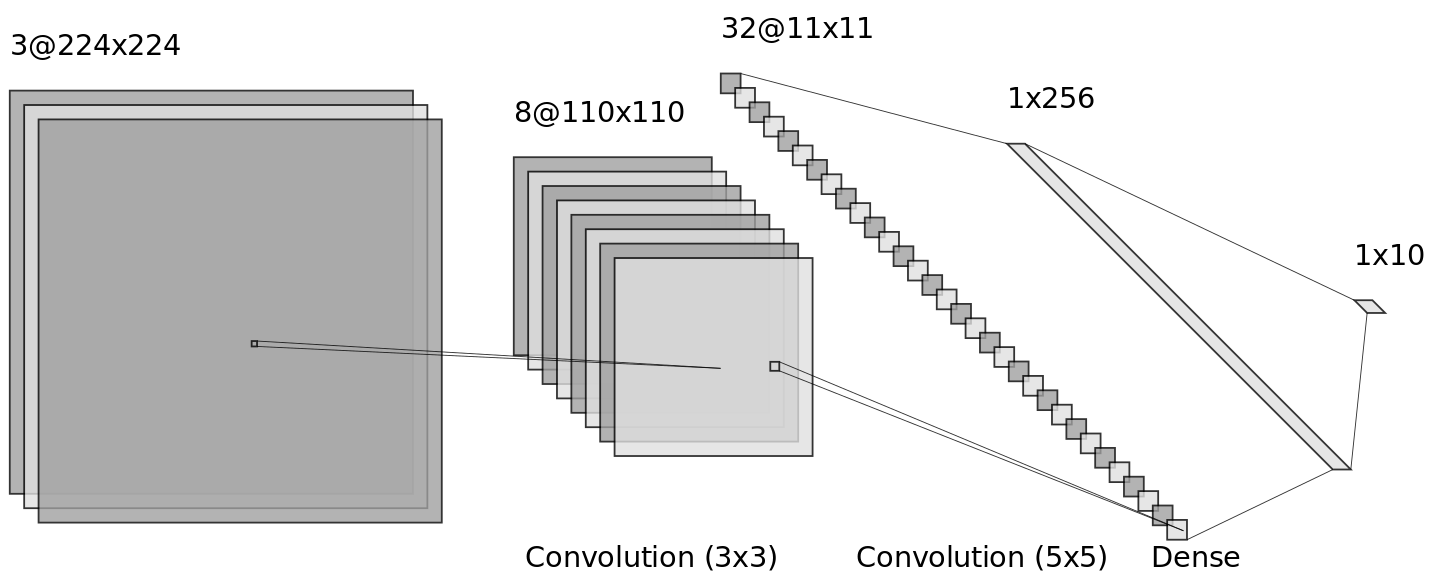

In [5]:
import torch.nn.functional as F


class YourModel(nn.Module):
    def __init__(self):
        # TO DO: Your neural network design
        super(YourModel, self).__init__()
        self.conv1 = nn.Conv2d(3, 8, 3, stride=2, dilation=3, padding=1, padding_mode="reflect")
        self.conv2 = nn.Conv2d(8, 32, 5, stride=5)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(32 * 5 * 5, 256)
        self.fc2 = nn.Linear(256, 10)
    def forward(self, x):
        # TO DO: Your neural network design
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 32 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [6]:
###  Here are some training parameters which you can tweak
batch_size = 64
learning_rate = 1e-3
regularization_rate = 1e-5
n_epochs = 20
use_gpu = True
test_every = 1
momentum = 0.9
###

# You may want to tweak them too and you can use different parameter settings for different models. 
# These are just examples
model = YourModel()
optimizer = optim.SGD(params=model.parameters(), lr=learning_rate, momentum=momentum, weight_decay=regularization_rate)
criteria = nn.CrossEntropyLoss()

## DataLoader

Here we provide you the codes for loading the train data, validation data and test data. Please ensure that you understood how PyTorch methods like ImageFolder, DataLoader and transformations work.

In [7]:
train_transforms = transforms.Compose([
            transforms.Resize(224),
            transforms.RandomHorizontalFlip(),
            transforms.ToTensor(),
            transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
        ])
val_transforms = transforms.Compose([
            transforms.Resize(224),
            transforms.ToTensor(),
            transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
        ])
test_transforms = transforms.Compose([
            transforms.Resize(224),
            transforms.ToTensor(),
            transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
        ])

abs_path = "/content/drive/MyDrive/ITU - Computer Engineering/BLG561E/HW2"
train_path = os.path.join(abs_path, 'data/train')
val_path = os.path.join(abs_path, 'data/val')
test_path = os.path.join(abs_path, 'data/test')
train_dataset = ImageFolder(train_path, train_transforms)
val_dataset = ImageFolder(val_path, val_transforms)
test_dataset = ImageFolder(test_path, test_transforms)

train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, num_workers=4, shuffle=True)
val_loader = DataLoader(dataset=val_dataset, batch_size=32, num_workers=4, shuffle=False)
test_loader = DataLoader(dataset=test_dataset, batch_size=32, num_workers=4, shuffle=False)

# Train your own model

Don't forget to include appropriate regularizations. Choose appropriate set of hyperparameters such as Learning Rate etc. You may insert new cells.

In [8]:
# It modifies the behaviour of modules like BatchNorm and Dropout for training purposes
# Use your own model
model.train()
if use_gpu:
    model.cuda()
    criteria.cuda()

# Some example diagnostics.

# Loss for every iteration
losses_iter_train = []
# Loss for epoch (averaging the iteration-wise loss)
losses_epoch_train = []
accuracy_iter_train = []
accuracy_epoch_train = []

losses_iter_val = []
losses_epoch_val = []
accuracy_iter_val = []
accuracy_epoch_val = []
running_loss = 0

# Write the training loop
for epoch in range(n_epochs):
    for ix, data in enumerate(train_loader):
        optimizer.zero_grad()
        img, label = data
        if use_gpu:
            img = img.cuda()
            label = label.cuda()
        output = model(img)
        loss = criteria(output, label)
        loss.backward()
        optimizer.step()

        # Statistics
        running_loss += loss.item()
        losses_iter_train.append(loss.item())
        if ix % 40 == 39:    # print every 80 mini-batches
            print('Train [%d, %5d] running loss: %.5f' % (epoch + 1, ix + 1, running_loss/40))
            running_loss = 0
    running_loss = 0
    losses_epoch_train.append(np.mean(losses_iter_train[epoch*len(train_loader):(epoch+1)*len(train_loader)]))
    print('Train [Epoch %d] loss: %.5f' % (epoch + 1, losses_epoch_train[epoch]))

    if epoch % test_every == 0:
        with torch.no_grad():
            model.eval()
            val_ix = epoch // test_every
            total_true = 0
            total_false = 0
            for ix, data in enumerate(val_loader):
                img, label = data
                if use_gpu:
                    img = img.cuda()
                    label = label.cuda()
                output = model(img)
                loss = criteria(output, label)
                _, prediction = torch.max(output.data, 1)
                total_true += torch.sum(prediction == label)
                total_false += torch.sum(prediction != label)
                # Statistics
                running_loss += loss.item()
                losses_iter_val.append(loss.item())
                # pdb.set_trace()
                if ix % 40 == 39:    # print every 40 mini-batches
                    print('Val [%d, %5d] running loss: %.5f' % (epoch + 1, ix + 1, running_loss/40))
                    running_loss = 0
            running_loss = 0
            losses_epoch_val.append(np.mean(losses_iter_val[val_ix*len(val_loader):(val_ix+1)*len(val_loader)]))
            print('Val [Epoch %d] loss: %.5f' % (epoch + 1, losses_epoch_val[val_ix]))
            print('Val Acc: {:.4}%'.format(100 * total_true / (total_true + total_false)))
        model.train()

Train [1,    40] running loss: 2.28606
Train [1,    80] running loss: 2.21847
Train [1,   120] running loss: 2.12484
Train [Epoch 1] loss: 2.18976
Val [1,    40] running loss: 2.03971
Val [Epoch 1] loss: 2.05901
Val Acc: 27.14%
Train [2,    40] running loss: 1.99343
Train [2,    80] running loss: 1.90976
Train [2,   120] running loss: 1.79982
Train [Epoch 2] loss: 1.87860
Val [2,    40] running loss: 1.78012
Val [Epoch 2] loss: 1.80610
Val Acc: 36.36%
Train [3,    40] running loss: 1.69482
Train [3,    80] running loss: 1.66806
Train [3,   120] running loss: 1.59034
Train [Epoch 3] loss: 1.64029
Val [3,    40] running loss: 1.65254
Val [Epoch 3] loss: 1.65422
Val Acc: 42.34%
Train [4,    40] running loss: 1.56514
Train [4,    80] running loss: 1.51854
Train [4,   120] running loss: 1.50590
Train [Epoch 4] loss: 1.52440
Val [4,    40] running loss: 1.59676
Val [Epoch 4] loss: 1.59625
Val Acc: 44.99%
Train [5,    40] running loss: 1.49216
Train [5,    80] running loss: 1.42456
Train [5, 

## Test your model

Measure the performance against test set. Complete the code below.

In [9]:
# It modifies the behaviour of modules like BatchNorm and Dropout for test purposes
# Dropout no longer works when .eval() is called.
# BatchNorm uses the learned parameters

model.eval()

with torch.no_grad():
    total_true = 0
    total_false = 0
    for data in test_loader:
        img, label = data
        if use_gpu:
            img = img.cuda()
            label = label.cuda()
        output = model(img)
        _, prediction = torch.max(output.data, 1)
        total_true += torch.sum(prediction == label)
        total_false += torch.sum(prediction != label)
        # Statistics
        # pdb.set_trace()
    print('Test Acc: {:.2f}%'.format(100 * total_true / (total_true + total_false)))

import copy
model_to_save = copy.deepcopy(model)

Test Acc: 59.26%


# Plot your model

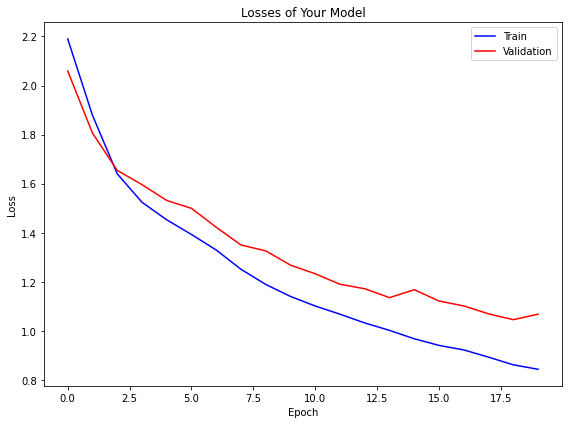

In [10]:
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(8, 6))
axes.plot(losses_epoch_train, c="b", label="Train")
axes.plot(losses_epoch_val, c="r", label="Validation")
axes.set_title("Losses of Your Model")
axes.set_xlabel("Epoch")
axes.set_ylabel("Loss")
axes.legend(loc="best")
fig.tight_layout()

My model has achieved pretty respectable validation and test accuracies considering how shallow the DNN is. Even though it is not very noticable at the first glance, the model will suffer from overfitting the training data. The momentum of the curves show us that as the number of epochs increase, we will start to see the gap between the validation and the training loss curves get wider.

# Train, Test and Plot Methods

These methods are defined below in order to reduce code duplication in the upcoming cells.

In [13]:
def train_model(train_loader, val_loader, model, optimizer, criterion, n_epochs=20, test_every=1, print_every=40):
    model.train()
    if use_gpu:
        model.cuda()
        criteria.cuda()

    losses_iter_train = []
    losses_epoch_train = []

    losses_iter_val = []
    losses_epoch_val = []
    running_loss = 0

    # Write the training loop
    for epoch in range(n_epochs):
        for ix, data in enumerate(train_loader):
            optimizer.zero_grad()
            img, label = data
            if use_gpu:
                img = img.cuda()
                label = label.cuda()
            output = model(img)
            loss = criterion(output, label)
            loss.backward()
            optimizer.step()

            # Statistics
            running_loss += loss.item()
            losses_iter_train.append(loss.item())
            if ix % print_every == print_every - 1:    # print every print_every iteration
                print('Train [%d, %5d] running loss: %.5f' % (epoch + 1, ix + 1, running_loss/print_every))
                running_loss = 0
        running_loss = 0
        losses_epoch_train.append(np.mean(losses_iter_train[epoch*len(train_loader):(epoch+1)*len(train_loader)]))
        print('Train [Epoch %d] loss: %.5f' % (epoch + 1, losses_epoch_train[epoch]))

        if epoch % test_every == 0:
            with torch.no_grad():
                model.eval()
                val_ix = epoch // test_every
                total_true = 0
                total_false = 0
                for ix, data in enumerate(val_loader):
                    img, label = data
                    if use_gpu:
                        img = img.cuda()
                        label = label.cuda()
                    output = model(img)
                    loss = criterion(output, label)
                    _, prediction = torch.max(output.data, 1)
                    total_true += torch.sum(prediction == label)
                    total_false += torch.sum(prediction != label)
                    # Statistics
                    running_loss += loss.item()
                    losses_iter_val.append(loss.item())
                    if ix % print_every == print_every - 1:
                        print('Val [%d, %5d] running loss: %.5f' % (epoch + 1, ix + 1, running_loss/print_every))
                        running_loss = 0
                running_loss = 0
                losses_epoch_val.append(np.mean(losses_iter_val[val_ix*len(val_loader):(val_ix+1)*len(val_loader)]))
                print('Val [Epoch %d] loss: %.5f' % (epoch + 1, losses_epoch_val[val_ix]))
                print('Acc: {:.4}%'.format(100 * total_true / (total_true + total_false)))
            model.train()

    return losses_iter_train, losses_epoch_train, losses_iter_val, losses_epoch_val

In [14]:
def test_model(test_loader, model):
    model.eval()

    with torch.no_grad():
        total_true = 0
        total_false = 0
        for data in test_loader:
            img, label = data
            if use_gpu:
                img = img.cuda()
                label = label.cuda()
            output = model(img)
            _, prediction = torch.max(output.data, 1)
            total_true += torch.sum(prediction == label)
            total_false += torch.sum(prediction != label)
            # Statistics
        test_acc = 100 * total_true / (total_true + total_false)
        print('Test Acc: {:.2f}%'.format(test_acc))
    
    return test_acc

In [15]:
def plot_model(train_losses, val_losses, title=None):
    fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(8, 6))
    axes.plot(train_losses, c="b", label="Train")
    axes.plot(val_losses, c="r", label="Validation")
    if title:
        axes.set_title(title)
    else:
        axes.set_title("Epoch Losses")
    axes.set_xlabel("Epoch")
    axes.set_ylabel("Loss")
    axes.legend(loc="best")
    fig.tight_layout()

# ResNet-50
## Train ResNet-50

Avoid overfitting and underfitting as much as possible. **Try to get highest validation and test accuracy (at least 65%)**

In [ ]:
# You can use the same training mechanism above. Now, you will use ResNet-50 as your model
model = resnet50
optimizer = optim.SGD(params=model.parameters(), lr=learning_rate, momentum=momentum, weight_decay=regularization_rate)
criteria = nn.CrossEntropyLoss()

_, resnet_train_losses, _, resnet_val_losses = train_model(train_loader, val_loader, model, optimizer, criteria, n_epochs=10)

Train [1,    40] running loss: 1.76868
Train [1,    80] running loss: 0.92061
Train [1,   120] running loss: 0.64264
Train [Epoch 1] loss: 1.03932
Val [1,    40] running loss: 0.50691
Val [Epoch 1] loss: 0.49535
Acc: 91.04%
Train [2,    40] running loss: 0.45814
Train [2,    80] running loss: 0.41773
Train [2,   120] running loss: 0.40305
Train [Epoch 2] loss: 0.42003
Val [2,    40] running loss: 0.36319
Val [Epoch 2] loss: 0.34832
Acc: 91.71%
Train [3,    40] running loss: 0.35166
Train [3,    80] running loss: 0.31052
Train [3,   120] running loss: 0.29235
Train [Epoch 3] loss: 0.31540
Val [3,    40] running loss: 0.28385
Val [Epoch 3] loss: 0.27997
Acc: 93.3%
Train [4,    40] running loss: 0.26664
Train [4,    80] running loss: 0.28206
Train [4,   120] running loss: 0.25997
Train [Epoch 4] loss: 0.26918
Val [4,    40] running loss: 0.25341
Val [Epoch 4] loss: 0.24494
Acc: 93.9%
Train [5,    40] running loss: 0.25526
Train [5,    80] running loss: 0.23302
Train [5,   120] running los

## Testing

In [ ]:
# You can use the same testing mechanism above. Now, you will use the ResNet model you trained above
resnet_acc = test_model(test_loader, model)

Test Acc: 70.16%


### Plot the training and validation losses versus number of iterations or epochs for ResNet-50 on the same plot and obtain test accuracy

Test Acc: 70.16%


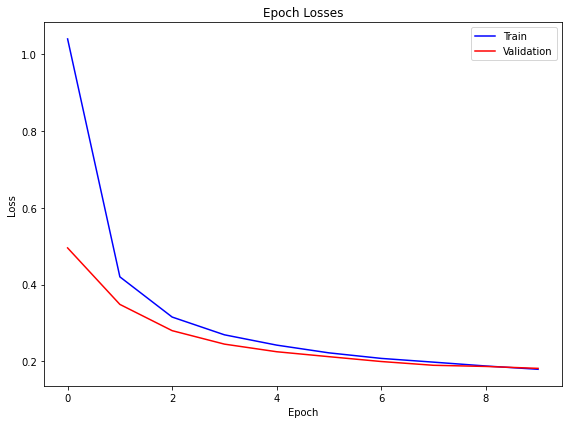

In [ ]:
print('Test Acc: {:.2f}%'.format(resnet_acc))
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(8, 6))
axes.plot(resnet_train_losses, c="b", label="Train")
axes.plot(resnet_val_losses, c="r", label="Validation")
axes.set_title("Epoch Losses")
axes.set_xlabel("Epoch")
axes.set_ylabel("Loss")
axes.legend(loc="best")
fig.tight_layout()

Pretrained ResNet50 has performed quite well on the validation set, however even though it neither overfit nor underfit the training data, its test set score isn't as remarkable as scores obtained on the validation set.

# DenseNet-121
## Train DenseNet-121

Avoid overfitting and underfitting as much as possible. **Try to get highest validation and test accuracy (at least 65%)**

In [ ]:
# You can use the same training mechanism above. Now, you will use DenseNet-121 as your model 
model = densenet121
optimizer = optim.SGD(params=model.parameters(), lr=learning_rate, momentum=momentum, weight_decay=regularization_rate)
criteria = nn.CrossEntropyLoss()

_, densenet_train_losses, _, densenet_val_losses = train_model(train_loader, val_loader, model, optimizer, criteria, n_epochs=10)

Train [1,    40] running loss: 1.72580
Train [1,    80] running loss: 0.92024
Train [1,   120] running loss: 0.62971
Train [Epoch 1] loss: 1.02528
Val [1,    40] running loss: 0.51679
Val [Epoch 1] loss: 0.50135
Acc: 87.86%
Train [2,    40] running loss: 0.47055
Train [2,    80] running loss: 0.42800
Train [2,   120] running loss: 0.38159
Train [Epoch 2] loss: 0.41811
Val [2,    40] running loss: 0.34977
Val [Epoch 2] loss: 0.34102
Acc: 91.9%
Train [3,    40] running loss: 0.33774
Train [3,    80] running loss: 0.32437
Train [3,   120] running loss: 0.29594
Train [Epoch 3] loss: 0.31672
Val [3,    40] running loss: 0.29651
Val [Epoch 3] loss: 0.28510
Acc: 92.44%
Train [4,    40] running loss: 0.29628
Train [4,    80] running loss: 0.27156
Train [4,   120] running loss: 0.25171
Train [Epoch 4] loss: 0.26968
Val [4,    40] running loss: 0.26438
Val [Epoch 4] loss: 0.25860
Acc: 92.57%
Train [5,    40] running loss: 0.26078
Train [5,    80] running loss: 0.22491
Train [5,   120] running lo

## Testing

In [ ]:
# You can use the same testing mechanism above. Now, you will use the DenseNet model you trained above 
densenet_acc = test_model(test_loader, model)

Test Acc: 86.47%


### Plot the training and validation losses versus number of iterations or epochs for DenseNet-121 on the same plot and obtain test accuracy

Test Acc: 86.47%


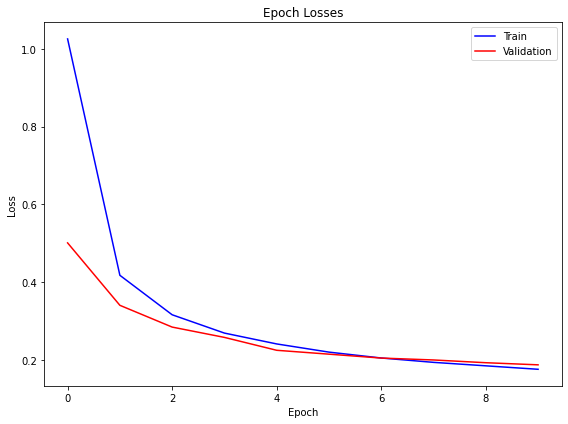

In [ ]:
print('Test Acc: {:.2f}%'.format(densenet_acc))
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(8, 6))
axes.plot(densenet_train_losses, c="b", label="Train")
axes.plot(densenet_val_losses, c="r", label="Validation")
axes.set_title("Epoch Losses")
axes.set_xlabel("Epoch")
axes.set_ylabel("Loss")
axes.legend(loc="best")
fig.tight_layout()

Pretrained DenseNet121 has performed quite well both on the validation set and the test set without any signs of over/under-fitting.

# BatchNorm Comparison

**Create two models one with batchnorm layers and one without batchnorm layers. Train them. If your YourModel() satisfies any of these conditions, you can use it for comparison.**

In [40]:
# Define your model with BatchNorm and train it. Skip this if you use YourModel() for this condition.
class BatchNormModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 8, 3, stride=2, dilation=3, padding=1, padding_mode="reflect")
        self.conv1_bn = nn.BatchNorm2d(self.conv1.out_channels)
        self.conv2 = nn.Conv2d(8, 32, 5, stride=5)
        self.conv2_bn = nn.BatchNorm2d(self.conv2.out_channels)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(32 * 5 * 5, 256)
        self.fc2 = nn.Linear(256, 10)
    def forward(self, x):
        x = self.pool(F.relu(self.conv1_bn(self.conv1(x))))
        x = self.pool(F.relu(self.conv2_bn(self.conv2(x))))
        x = x.view(-1, 32 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x


bn_model = BatchNormModel()
bnmodel_optimizer = optim.SGD(bn_model.parameters(), lr=learning_rate, momentum=momentum, weight_decay=regularization_rate)
_, bnmodel_train_losses, _, bnmodel_val_losses = train_model(train_loader, val_loader, bn_model, bnmodel_optimizer, criteria)

Train [1,    40] running loss: 2.17125
Train [1,    80] running loss: 1.88081
Train [1,   120] running loss: 1.71690
Train [Epoch 1] loss: 1.88464
Val [1,    40] running loss: 1.68372
Val [Epoch 1] loss: 1.65162
Acc: 43.99%
Train [2,    40] running loss: 1.55885
Train [2,    80] running loss: 1.45304
Train [2,   120] running loss: 1.39144
Train [Epoch 2] loss: 1.45202
Val [2,    40] running loss: 1.47266
Val [Epoch 2] loss: 1.44363
Acc: 49.5%
Train [3,    40] running loss: 1.31132
Train [3,    80] running loss: 1.28391
Train [3,   120] running loss: 1.24846
Train [Epoch 3] loss: 1.27088
Val [3,    40] running loss: 1.30170
Val [Epoch 3] loss: 1.27731
Acc: 56.93%
Train [4,    40] running loss: 1.17784
Train [4,    80] running loss: 1.12486
Train [4,   120] running loss: 1.07642
Train [Epoch 4] loss: 1.12260
Val [4,    40] running loss: 1.15947
Val [Epoch 4] loss: 1.15722
Acc: 59.79%
Train [5,    40] running loss: 1.07615
Train [5,    80] running loss: 1.03984
Train [5,   120] running lo

In [28]:
# Define your model without BatchNorm and train it. Skip this if you use YourModel() for this condition.
your_model = YourModel()
yourmodel_optimizer = optim.SGD(your_model.parameters(), lr=learning_rate, momentum=momentum, weight_decay=regularization_rate)
_, yourmodel_train_losses, _, yourmodel_val_losses = train_model(train_loader, val_loader, your_model, yourmodel_optimizer, criteria)

Train [1,    40] running loss: 2.28454
Train [1,    80] running loss: 2.20417
Train [1,   120] running loss: 2.15824
Train [Epoch 1] loss: 2.19990
Val [1,    40] running loss: 2.12466
Val [Epoch 1] loss: 2.09508
Acc: 28.33%
Train [2,    40] running loss: 2.06023
Train [2,    80] running loss: 1.91683
Train [2,   120] running loss: 1.83289
Train [Epoch 2] loss: 1.92107
Val [2,    40] running loss: 1.82178
Val [Epoch 2] loss: 1.81995
Acc: 37.82%
Train [3,    40] running loss: 1.78116
Train [3,    80] running loss: 1.73677
Train [3,   120] running loss: 1.68770
Train [Epoch 3] loss: 1.73157
Val [3,    40] running loss: 1.70981
Val [Epoch 3] loss: 1.73330
Acc: 39.28%
Train [4,    40] running loss: 1.68293
Train [4,    80] running loss: 1.62392
Train [4,   120] running loss: 1.57436
Train [Epoch 4] loss: 1.62094
Val [4,    40] running loss: 1.62770
Val [Epoch 4] loss: 1.64280
Acc: 42.47%
Train [5,    40] running loss: 1.55246
Train [5,    80] running loss: 1.50643
Train [5,   120] running l

**For each, plot the training and validation losses versus number of iterations or epochs and compare test accuracies.**

Test Acc: 55.77%


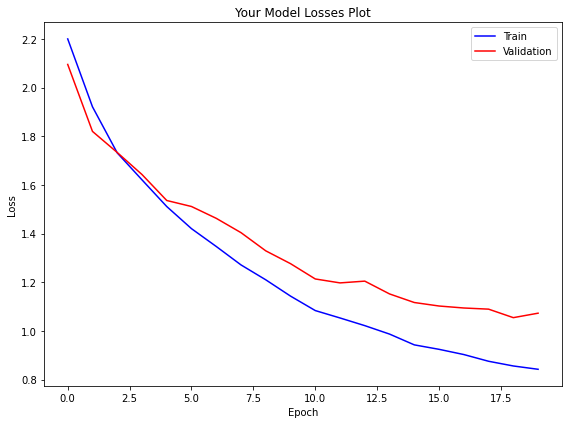

In [29]:
yourmodel_acc = test_model(test_loader, your_model)
plot_model(yourmodel_train_losses, yourmodel_val_losses, "Your Model Losses Plot")

Test Acc: 57.98%


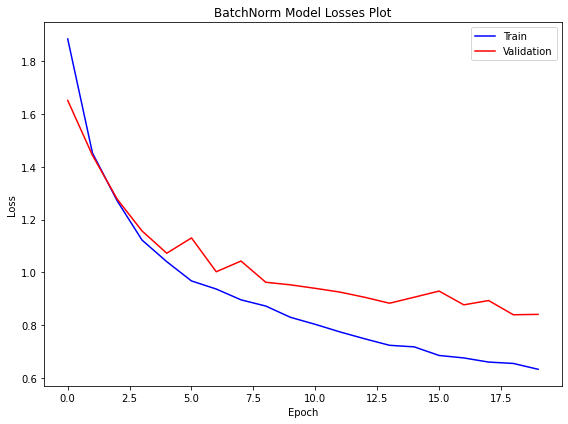

In [41]:
bnmodel_acc = test_model(test_loader, bn_model)
plot_model(bnmodel_train_losses, bnmodel_val_losses, "BatchNorm Model Losses Plot")

Batch normalization helped generalize the data better, increased the accuracy and the stability of our network as expected. By normalizing the intermediary values, it allowed our network layers to learn independently from one another. Please note that the test accuracy of YourModel() differs from the initial one because weights are randomly initialized each run and YourModel() is trained from scratch TWICE. This is intentional in order to show the results in a more compact fashion.

# Dropout Comparison

**Create two models one with dropout layers and one without dropout layers. Train them. If your YourModel() satisfies any of these conditions, you can use it for comparison.**

In [42]:
# Define your model with Dropout and train it. Skip this if you use YourModel() for this condition.
class DropoutModel(nn.Module):
    def __init__(self, p=0.5):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 8, 3, stride=2, dilation=3, padding=1, padding_mode="reflect")
        self.conv2 = nn.Conv2d(8, 32, 5, stride=5)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(32 * 5 * 5, 256)
        self.fc2 = nn.Linear(256, 10)
        self.dropout = nn.Dropout(p)
    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 32 * 5 * 5)
        x = F.relu(self.dropout(self.fc1(x)))
        x = self.dropout(self.fc2(x))
        return x


dropout_model = DropoutModel(p=0.2)
dropoutmodel_optimizer = optim.SGD(dropout_model.parameters(), lr=learning_rate, momentum=momentum, weight_decay=regularization_rate)
_, dropoutmodel_train_losses, _, dropoutmodel_val_losses = train_model(train_loader, val_loader, dropout_model, dropoutmodel_optimizer, criteria)

Train [1,    40] running loss: 2.27257
Train [1,    80] running loss: 2.20701
Train [1,   120] running loss: 2.13349
Train [Epoch 1] loss: 2.18801
Val [1,    40] running loss: 2.02889
Val [Epoch 1] loss: 2.03487
Acc: 29.0%
Train [2,    40] running loss: 2.00113
Train [2,    80] running loss: 1.92473
Train [2,   120] running loss: 1.91799
Train [Epoch 2] loss: 1.94075
Val [2,    40] running loss: 1.83070
Val [Epoch 2] loss: 1.83040
Acc: 37.76%
Train [3,    40] running loss: 1.86437
Train [3,    80] running loss: 1.80157
Train [3,   120] running loss: 1.80657
Train [Epoch 3] loss: 1.81989
Val [3,    40] running loss: 1.70727
Val [Epoch 3] loss: 1.72005
Acc: 41.94%
Train [4,    40] running loss: 1.74309
Train [4,    80] running loss: 1.69613
Train [4,   120] running loss: 1.70875
Train [Epoch 4] loss: 1.71462
Val [4,    40] running loss: 1.64855
Val [Epoch 4] loss: 1.62194
Acc: 44.72%
Train [5,    40] running loss: 1.65689
Train [5,    80] running loss: 1.65644
Train [5,   120] running lo

In [ ]:
# Define your model without Dropout and train it. Skip this if you use YourModel() for this condition.

**For each, plot the training and validation losses versus number of iterations or epochs and compare test accuracies.**

Test Acc: 55.77%


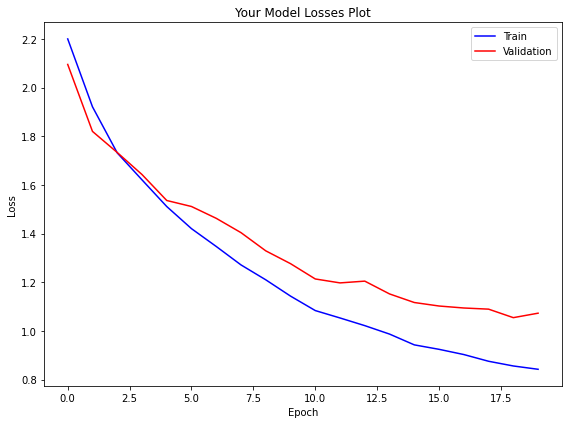

In [32]:
yourmodel_acc = test_model(test_loader, your_model)
plot_model(yourmodel_train_losses, yourmodel_val_losses, "Your Model Losses Plot")

Test Acc: 57.83%


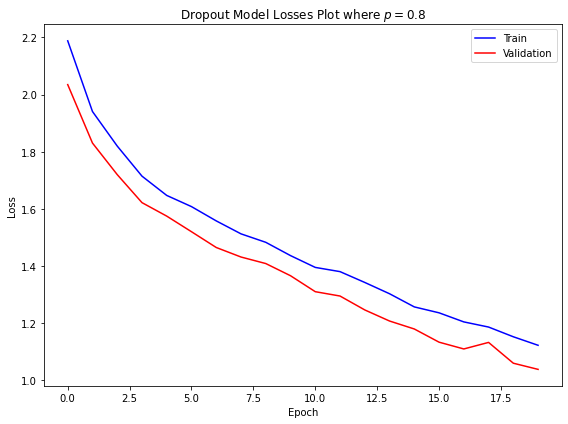

In [43]:
dropoutmodel_acc = test_model(test_loader, dropout_model)
plot_model(dropoutmodel_train_losses, dropoutmodel_val_losses, "Dropout Model Losses Plot where $p=0.2$")

A similar conclusion can be made for the dropout as well. By randomly choosing which neurons to activate at each run, our model generalized to the data better and achieved higher accuracy results. It should also be noted that $p$ is not the probability to keep to neurons as implemented in the homework. In PyTorch, $p$ is the probability to zero out a random neuron.

# Optimizer Comparison

**Optimize two identical models one with SGD+Momentum and one with Adam. If your training for YourModel() satisfies any of these conditions, you can use it for comparison.**

In [ ]:
# Train your model with SGD+Momentum. Skip this if you use YourModel() for this condition.

In [ ]:
# Train your model with Adam. Skip this if you use YourModel() for this condition.
adam_model = YourModel()
adam_optimizer = optim.Adam(adam_model.parameters(), lr=learning_rate, weight_decay=regularization_rate)
_, adam_train_losses, _, adam_val_losses = train_model(train_loader, val_loader, adam_model, adam_optimizer, criteria)

Train [1,    40] running loss: 1.92992
Train [1,    80] running loss: 1.54143
Train [1,   120] running loss: 1.34074
Train [Epoch 1] loss: 1.55730
Val [1,    40] running loss: 1.39325
Val [Epoch 1] loss: 1.40337
Acc: 51.16%
Train [2,    40] running loss: 1.17799
Train [2,    80] running loss: 1.12448
Train [2,   120] running loss: 1.07885
Train [Epoch 2] loss: 1.11447
Val [2,    40] running loss: 1.10694
Val [Epoch 2] loss: 1.14104
Acc: 60.45%
Train [3,    40] running loss: 1.01225
Train [3,    80] running loss: 0.97355
Train [3,   120] running loss: 0.96825
Train [Epoch 3] loss: 0.98041
Val [3,    40] running loss: 1.06369
Val [Epoch 3] loss: 1.10352
Acc: 62.18%
Train [4,    40] running loss: 0.87406
Train [4,    80] running loss: 0.87949
Train [4,   120] running loss: 0.91074
Train [Epoch 4] loss: 0.89162
Val [4,    40] running loss: 1.02286
Val [Epoch 4] loss: 1.03848
Acc: 64.96%
Train [5,    40] running loss: 0.79786
Train [5,    80] running loss: 0.84492
Train [5,   120] running l

**For each, plot the training and validation losses versus number of iterations or epochs and compare test accuracies**

Test Acc: 55.77%


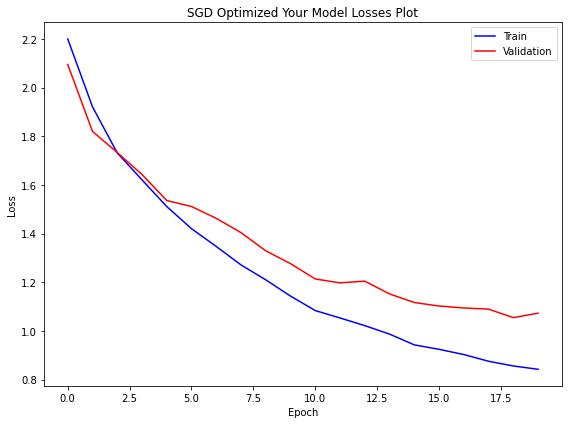

In [44]:
sgd_acc = test_model(test_loader, your_model)
plot_model(yourmodel_train_losses, yourmodel_val_losses, "SGD Optimized Your Model Losses Plot")

Test Acc: 58.83%


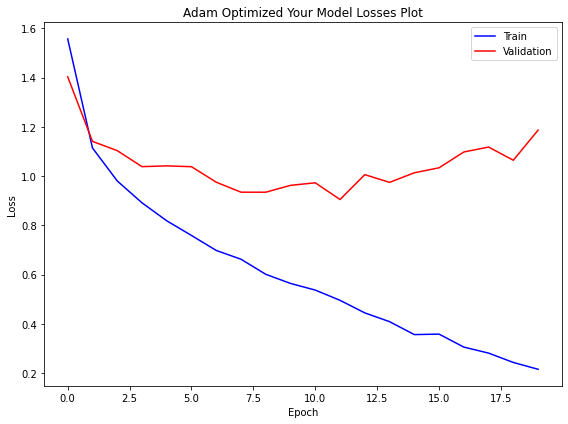

In [ ]:
adam_acc = test_model(test_loader, adam_model)
plot_model(adam_train_losses, adam_val_losses, "Adam Optimized Your Model Losses Plot")

Adam optimizer has helped the model to learn and fit to the data a lot faster than SGD, by taking optimization steps resulted from computation of the decaying average of past squared gradients (RMSProp alike) and past gradients (SGD with momentum alike). Thanks to this, we can now observe within 10 to 12 epochs that our model is not sufficient enough to generalize and needs to be deeper. By increasing the number of convolutions and kernels, we can allow our model to learn more features.

#### After you have completed the training, save your best model using the following command
#### Upload your best model to Google Drive and copy your link here: [Link to Model](https://drive.google.com/file/d/1KeUnEBfPK2QBzhlc-F6iTkf_YD3RIcar/view?usp=sharing) (https://drive.google.com/file/d/1KeUnEBfPK2QBzhlc-F6iTkf_YD3RIcar/view?usp=sharing)

In [11]:
student_id = 150180705
model_path = os.path.join(abs_path, '{}.pth'.format(student_id))
torch.save(model_to_save.state_dict(), model_path)